# Examples

## Single row of turbines

Library import for this example:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV

The `foxes` setup consists of creating: 

1. the so-called `model book`, which contains all selectable models,
2. ambient wind conditions, called `states` in `foxes` terminology,
3. the `wind farm`, collecting all turbine information,
4. the `algorithm` with its parameters and model choices.

Here is a simple example for a single row of turbines along the x axis and a uniform wind speed with wind direction 270°:

In [2]:
# Create model book and add turbine type model:
# The csv file will be searched in the file system,
# and if not found, taken from static library
mbook = foxes.ModelBook()
mbook.turbine_types["NREL5"] = foxes.models.turbine_types.PCtFile("NREL-5MW-D126-H90.csv")

# create ambient wind conditions, a single uniform state:
states = foxes.input.states.SingleStateStates(ws=9., wd=270., ti=0.06, rho=1.225)

# create wind farm, a single row of turbines:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_row(
    farm=farm,
    xy_base=[0., 0.], 
    xy_step=[800., 0.], 
    n_turbines=5,
    turbine_models=["NREL5"],
    verbosity=0
)

# setup the calculation algorithm:
algo = foxes.algorithms.Downwind(mbook, farm, states, verbosity=0,
                                 wake_models=["Bastankhah_linear_k002"])

Now we can ask the `algorithm` object to run the calculation. This returns a `xarray.Dataset` object with results for each state and turbine:

In [3]:
farm_results = algo.calc_farm()
print("\nFarm results:\n", farm_results)


Farm results:
 <xarray.Dataset>
Dimensions:    (state: 1, turbine: 5)
Dimensions without coordinates: state, turbine
Data variables: (12/24)
    weight     (state, turbine) float64 1.0 1.0 1.0 1.0 1.0
    X          (state, turbine) float64 0.0 800.0 1.6e+03 2.4e+03 3.2e+03
    Y          (state, turbine) float64 0.0 0.0 0.0 0.0 0.0
    H          (state, turbine) float64 90.0 90.0 90.0 90.0 90.0
    D          (state, turbine) float64 126.0 126.0 126.0 126.0 126.0
    P          (state, turbine) float64 2.519e+03 1.2e+03 828.0 667.2 588.9
    ...         ...
    AMB_REWS3  (state, turbine) float64 9.0 9.0 9.0 9.0 9.0
    AMB_TI     (state, turbine) float64 0.06 0.06 0.06 0.06 0.06
    AMB_RHO    (state, turbine) float64 1.225 1.225 1.225 1.225 1.225
    order      (state, turbine) float64 0.0 1.0 2.0 3.0 4.0
    AMB_P      (state, turbine) float64 2.519e+03 2.519e+03 ... 2.519e+03
    AMB_CT     (state, turbine) float64 0.79 0.79 0.79 0.79 0.79


For a convenient summary printout we can easily convert the results into a `pandas.DataFrame`:

In [4]:
fr = farm_results.to_dataframe()
print(fr[[FV.WD, FV.AMB_REWS, FV.REWS, FV.TI, FV.AMB_P, FV.P, FV.CT]])

                  WD  AMB_REWS      REWS    TI   AMB_P            P        CT
state turbine                                                                
0     0        270.0       9.0  9.000000  0.06  2518.6  2518.600000  0.790000
      1        270.0       9.0  7.021409  0.06  2518.6  1199.700834  0.809786
      2        270.0       9.0  6.201127  0.06  2518.6   828.026917  0.849944
      3        270.0       9.0  5.789114  0.06  2518.6   667.227255  0.870544
      4        270.0       9.0  5.554529  0.06  2518.6   588.946491  0.882274


Once the farm calculation results are ready, we can evaluate the wake corrected flow and all points of interest. For example, we can evaluate the wind speed along the centre line:


Point results:
 <xarray.Dataset>
Dimensions:  (state: 1, point: 8000)
Dimensions without coordinates: state, point
Data variables:
    WS       (state, point) float64 9.0 9.0 9.0 9.0 ... 8.722 8.722 8.722 8.722
    WD       (state, point) float64 270.0 270.0 270.0 ... 270.0 270.0 270.0
    TI       (state, point) float64 0.06 0.06 0.06 0.06 ... 0.06 0.06 0.06 0.06
    RHO      (state, point) float64 1.225 1.225 1.225 ... 1.225 1.225 1.225
    AMB_WS   (state, point) float64 9.0 9.0 9.0 9.0 9.0 ... 9.0 9.0 9.0 9.0 9.0
    AMB_WD   (state, point) float64 270.0 270.0 270.0 ... 270.0 270.0 270.0
    AMB_TI   (state, point) float64 0.06 0.06 0.06 0.06 ... 0.06 0.06 0.06 0.06
    AMB_RHO  (state, point) float64 1.225 1.225 1.225 ... 1.225 1.225 1.225


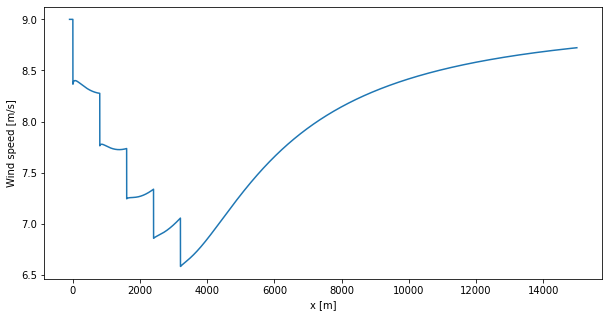

In [5]:
# create points of interest, shape (n_states, n_points, 3):
n_points = 8000
points   = np.zeros((1, n_points, 3))
points[:, :, 0] = np.linspace(-100., 15000., n_points)[None, :]

# calculate point results:
point_results = algo.calc_points(farm_results, points)
print("\nPoint results:\n", point_results)

# create figure:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(points[0, :, 0], point_results[FV.WS][0, :])
ax.set_xlabel("x [m]")
ax.set_ylabel("Wind speed [m/s]")
plt.show()

Using the `foxes.output` package, we can fox example visualize the flow in a horizontal slice at hub height:

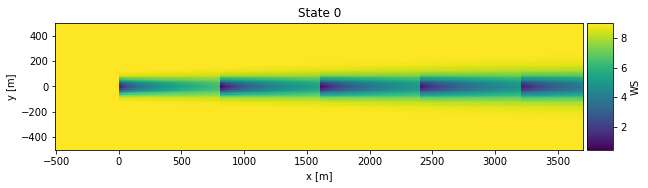

In [6]:
o   = foxes.output.FlowPlots2D(algo, farm_results)
g   = o.gen_states_fig_horizontal("WS", resolution=10, figsize=(10,5), verbosity=0)
fig = next(g) # creates the figure for the next state, here there is only state 0
plt.show()